In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:203: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8395061728395061, Loss: 0.6537798422354238
Checkpoint 200, Accuracy: 0.845679012345679, Loss: 0.6535941936351635
Checkpoint 300, Accuracy: 0.845679012345679, Loss: 0.6541356687192563
Checkpoint 400, Accuracy: 0.845679012345679, Loss: 0.6504429004810475
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6521378269901982


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.86853915]
 [0.09625723]
 [0.03520365]]
[0. 1. 0.] <-> [[0.64835495]
 [0.23246801]
 [0.1191771 ]]
[1. 0. 0.] <-> [[0.85847497]
 [0.10431794]
 [0.03720708]]
[1. 0. 0.] <-> [[0.76299536]
 [0.16877268]
 [0.06823198]]
[1. 0. 0.] <-> [[0.8343923 ]
 [0.12233629]
 [0.04327142]]
[0. 1. 0.] <-> [[0.36189044]
 [0.36617523]
 [0.27193433]]
[1. 0. 0.] <-> [[0.81537557]
 [0.13554426]
 [0.04908027]]
[1. 0. 0.] <-> [[0.78283274]
 [0.15662849]
 [0.06053878]]
[1. 0. 0.] <-> [[0.8993459 ]
 [0.0691304 ]
 [0.03152367]]
[0. 1. 0.] <-> [[0.34863406]
 [0.37174377]
 [0.27962214]]
[0. 0. 1.] <-> [[0.9298946 ]
 [0.03742128]
 [0.03268406]]
[1. 0. 0.] <-> [[0.7628048]
 [0.1688872]
 [0.068308 ]]
[1. 0. 0.] <-> [[0.92552775]
 [0.04229728]
 [0.03217499]]
[1. 0. 0.] <-> [[0.6475176 ]
 [0.2329035 ]
 [0.11957888]]
[0. 1. 0.] <-> [[0.78955483]
 [0.15240332]
 [0.0580418 ]]
[0. 0. 1.] <-> [[0.90940744]
 [0.0593115 ]
 [0.03128113]]
[0. 0. 1.] <-> [[0.00623487]
 [0.30157438]
 [0.6921907 ]]
[0. 0. 1.] <-> [[

In [11]:
# Testing Performance

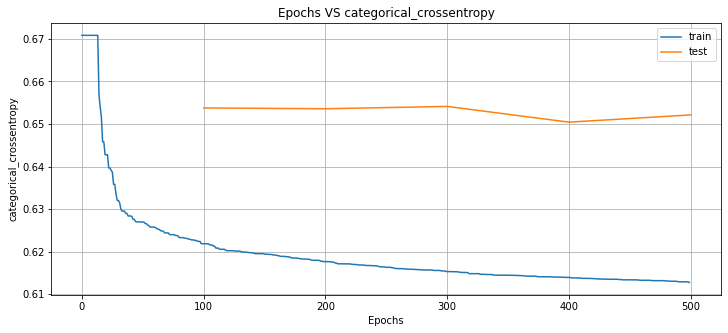

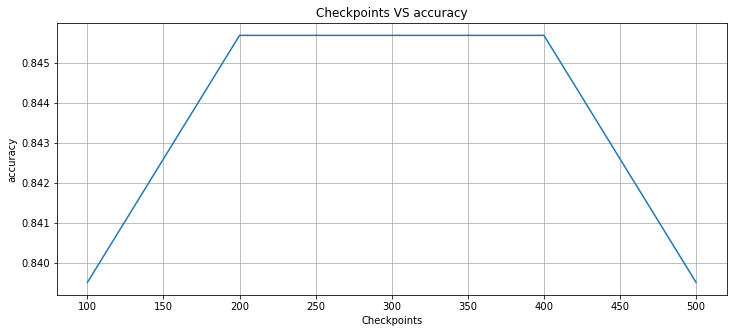

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8395061728395061, 'mean_square_error': 2.994453897410066, 'categorical_crossentropy': 0.6537798422354238, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.845679012345679, 'mean_square_error': 2.9630079362860706, 'categorical_crossentropy': 0.6535941936351635, 'precision': 0.7685185185185185, 'recall': 0.7685185185185185, 'f1': 0.7685185185185186, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 3, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 13}, 2: {'tp_hit': 3, 'fp_hit': 3, 'tn_hit': 91, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.845679012345679, 'mean_square_error': 2.9741292735688254, 'categorical_crossentropy': 0.6541356687192563, 'precision': 0.

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.02317989]
 [-1.9835913 ]
 [ 1.3638674 ]
 [ 1.9077042 ]
 [-0.83135754]]
 bias: [-2.4805038]

Neuron 1: weights:
[[-1.8950846]
 [-0.7309148]
 [ 1.7976307]
 [-0.6415389]
 [ 2.7163117]]
 bias: [-3.]

Neuron 2: weights:
[[-1.4010837]
 [-0.8018632]
 [ 1.57514  ]
 [ 0.9333168]
 [-1.7534717]]
 bias: [-2.7823484]

Neuron 3: weights:
[[-1.5539609 ]
 [ 2.931453  ]
 [-2.155109  ]
 [ 0.84420097]
 [-0.9628994 ]]
 bias: [0.76031244]

$
Layer 2
Neuron 0: weights:
[[ 0.08824176]
 [-3.        ]
 [ 0.09570826]
 [ 1.5396382 ]]
 bias: [-2.319514]

Neuron 1: weights:
[[-2.500158 ]
 [ 2.408892 ]
 [-1.2305079]
 [-0.5907315]]
 bias: [-2.3462892]

Neuron 2: weights:
[[ 2.9525652 ]
 [ 0.59467584]
 [ 0.9315251 ]
 [-2.8273606 ]]
 bias: [-2.1844685]

$

